In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import display  #To display multiple outputs from a cell
pd.set_option('display.max_rows', 100) #Limit max number of rows to display

#### Task is to predict conversion rate

Dataset description:

country : user country based on the IP address  
age : user age. Self-reported at sign-in step  
new_user : whether the user created the account during this session or had already an account and simply came back to the site  
source : marketing channel source  
         * Ads: came to the site by clicking on an advertisement  
         * Seo: came to the site by clicking on search results  
         * Direct: came to the site by directly typing the URL on the browser  
total_pages_visited: number of total pages visited during the session  
converted: this is our label. 1 means they converted within the session, 0 means they left without buying anything.  

### Load Data

In [2]:
df = pd.read_csv('dataset/conversion_data.csv')
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


### Preliminary Exploration

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [4]:
# Summary of quantitative variables
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [5]:
# Summary of qualitative variables
df.describe(exclude = [np.number])

,country,source
count,316200,316200
unique,4,3
top,US,Seo
freq,178092,155040


In [6]:
# Qualitative variable categories and their counts - Before imputing missing values NAN is taken as another category

for col_name in df.columns:
    if df[col_name].dtypes == 'object':
        unique_cat = len(df[col_name].unique())
        cat = df[col_name].value_counts().sort_values(ascending=False)
        print("Feature '{col_name}' has {unique_cat} unique categories".format(col_name=col_name, unique_cat=unique_cat))
        print(cat)

Feature 'country' has 4 unique categories
US         178092
China       76602
UK          48450
Germany     13056
Name: country, dtype: int64
Feature 'source' has 3 unique categories
Seo       155040
Ads        88740
Direct     72420
Name: source, dtype: int64


### Data Cleaning - Duplicates, Missing Values and Outliers

In [7]:
# Display duplicate records
df[df.duplicated() == True]

,country,age,new_user,source,total_pages_visited,converted
88,US,28,1,Seo,4,0
89,US,25,1,Ads,5,0
110,US,29,0,Ads,5,0
144,US,37,1,Direct,7,0
148,US,19,1,Ads,3,0
...,...,...,...,...,...,...
316195,US,26,1,Ads,9,0
316196,US,27,1,Direct,6,0
316197,China,25,0,Ads,4,0
316198,US,22,0,Seo,4,0


In [8]:
# Drop duplicate records
df = df.drop_duplicates()

In [9]:
# Check how many records are remaining
df.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            315084, 315234, 315257, 315398, 315521, 315659, 315777, 315892,
            316076, 316098],
           dtype='int64', length=16297)

In [10]:
# Display all records containing missing data
df[df.isnull().any(axis=1)]

,country,age,new_user,source,total_pages_visited,converted


In [11]:
# Count of Missing values per column
df.isnull().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

In [12]:
# Check imbalance in data set
df['converted'].value_counts()

0    11969
1     4328
Name: converted, dtype: int64

In [13]:
# Check Outliers
df.describe()

,age,new_user,total_pages_visited,converted
count,16297.000000,16297.000000,16297.000000,16297.00000
mean,33.847702,0.500153,9.004541,0.26557
std,11.460386,0.500015,5.423338,0.44165
min,17.000000,0.000000,1.000000,0.00000
25%,24.000000,0.000000,5.000000,0.00000
50%,32.000000,1.000000,9.000000,0.00000
75%,42.000000,1.000000,13.000000,1.00000
max,123.000000,1.000000,29.000000,1.00000


In [14]:
# Remove outliers i.e. age > 100
df = df.loc[df.age < 100]

### Datatype Conversion of Columns

In [15]:
df.dtypes

country                object
age                     int64
new_user                int64
source                 object
total_pages_visited     int64
converted               int64
dtype: object

In [16]:
# Can be done only after imputation
# new_user is effectively a categorical variable - 1 and 0
# target - converted is also effectively a categorical variable
df['new_user'] = df['new_user'].astype('object') 
df['converted'] = df['converted'].astype('object')

In [17]:
df.dtypes

country                object
age                     int64
new_user               object
source                 object
total_pages_visited     int64
converted              object
dtype: object

### Exploratory Data Analysis

In [18]:
# Qualitative variable categories and their counts - After imputing missing values else it will take NAN as another category

for col_name in df.columns:
    if df[col_name].dtypes == 'object':
        unique_cat = len(df[col_name].unique())
        cat = df[col_name].value_counts().sort_values(ascending=False)
        print("Feature '{col_name}' has {unique_cat} unique categories".format(col_name=col_name, unique_cat=unique_cat))
        print(cat)

Feature 'country' has 4 unique categories
US         5814
UK         4312
China      3312
Germany    2857
Name: country, dtype: int64
Feature 'new_user' has 2 unique categories
1    8151
0    8144
Name: new_user, dtype: int64
Feature 'source' has 3 unique categories
Seo       6091
Ads       5300
Direct    4904
Name: source, dtype: int64
Feature 'converted' has 2 unique categories
0    11969
1     4326
Name: converted, dtype: int64


In [19]:
# List of numeric columns
num_cols = []

for col_name in df.columns:
    if df[col_name].dtypes != 'object':
        num_cols.append(col_name)   
        
print(num_cols)

['age', 'total_pages_visited']


In [20]:
# List of categorical columns
cat_cols = []

for col_name in df.columns:
    if df[col_name].dtypes == 'object':
        cat_cols.append(col_name)  
        
print(cat_cols)

['country', 'new_user', 'source', 'converted']


#### Univariate Analysis

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


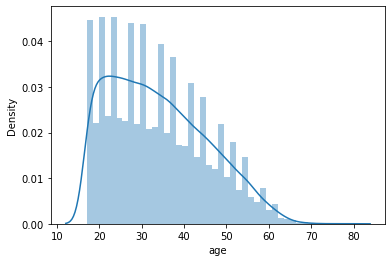

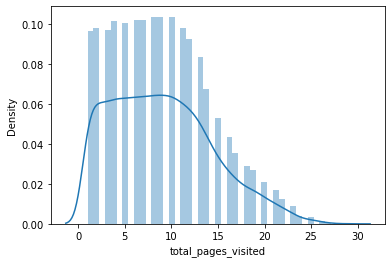

In [21]:
# Histogram + KDE of numeric variables 
for i,col_name in enumerate(num_cols):
    plt.figure(i)
    sns.distplot(df[col_name])

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


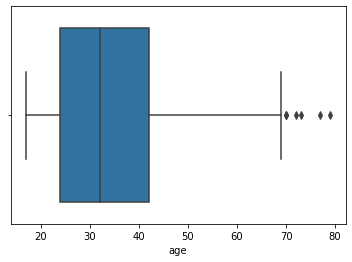

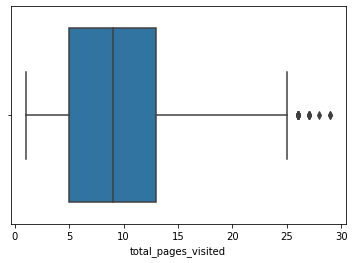

In [22]:
# Boxplot of numeric variables
for i,col_name in enumerate(num_cols):
    plt.figure(i)
    sns.boxplot(df[col_name])
    
# Note: Outliers cannot be defined here just by IQR in individual columns

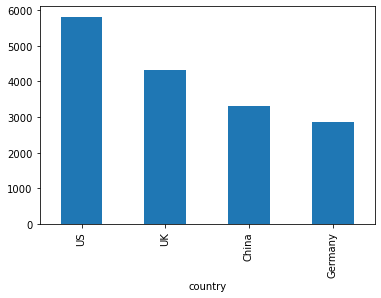

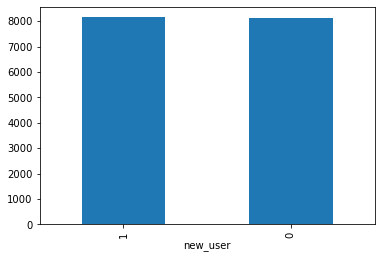

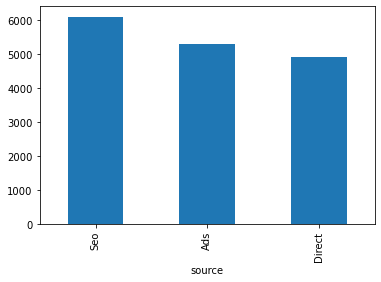

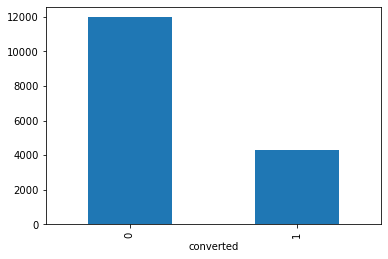

In [23]:
# Bar plot for frequency of categories in categorical variables
for i,col_name in enumerate(cat_cols):
    plt.figure(i)
    df[col_name].value_counts().plot(kind='bar')
    plt.xlabel(col_name)

#### Bivariate Analysis

Understand that an observed association between two variables can be misleading or even reverse direction when there is another
variable that interacts strongly with both variables (Simpson's Paradox)

In [24]:
# For better readability in plots 
df['converted'] = df['converted'].replace([0, 1], ['No', 'Yes'])

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


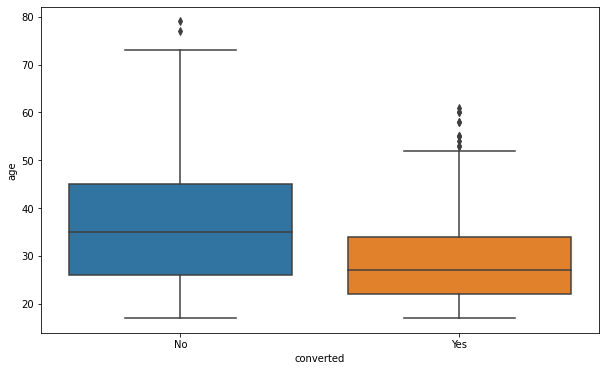

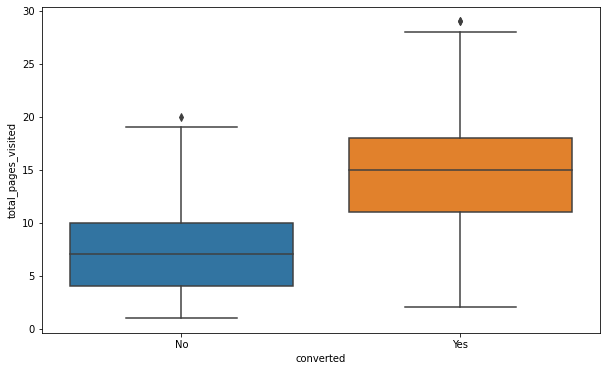

In [25]:
# Boxplot of target variable w.r.t. continuous variables
target = 'converted'
for i,col_name in enumerate(num_cols):
    plt.figure(i, figsize = (10,6))
    sns.boxplot(df[target], df[col_name])

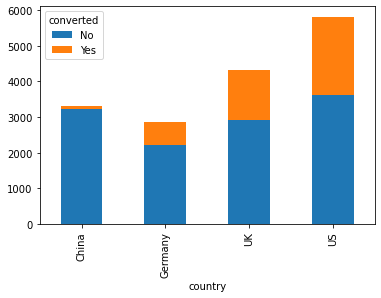

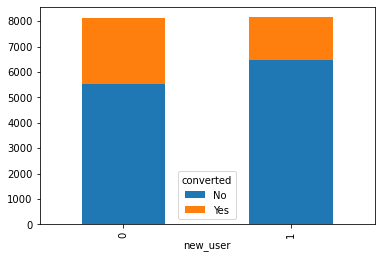

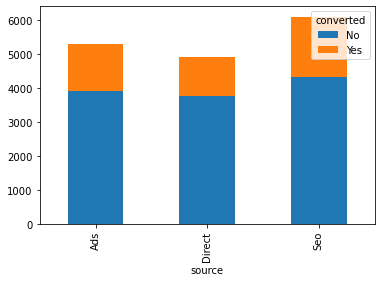

In [26]:
# Stacked Barplot of target variable w.r.t. categorical variable
target = 'converted'

cat_cols.remove(target)

for col_name in cat_cols:
    table = pd.crosstab(df[col_name], df[target])
    table.plot(kind='bar', stacked=True) 

#### Multivariate Analysis

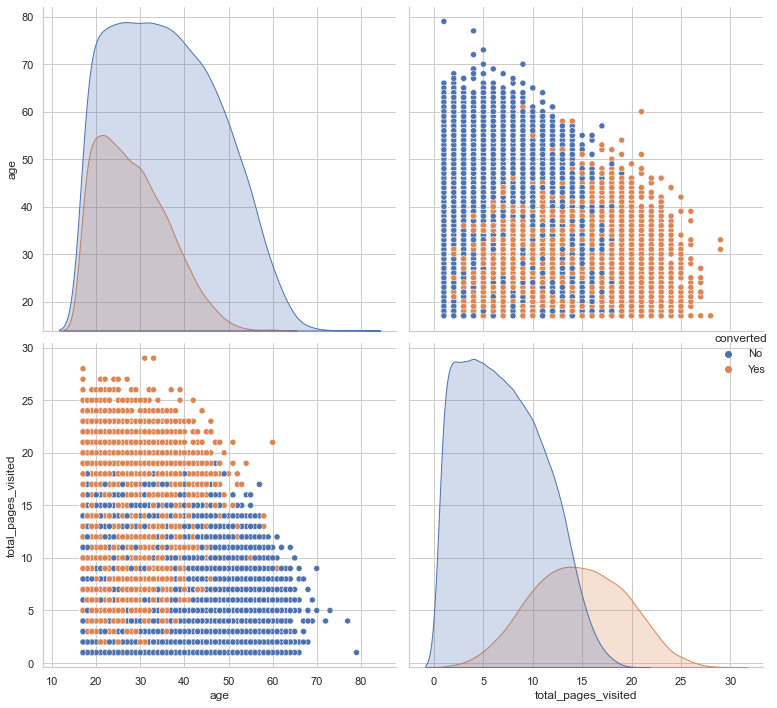

In [27]:
# Scatter plot matrix of numeric variables w.r.t. target (To check shape of decision boundary)
target = 'converted'

cols = cat_cols
df_num = df.drop(cols, axis=1)

sns.set(style='whitegrid', context='notebook')
sns.pairplot(df_num, hue=target, height=5)
plt.tight_layout()
plt.show()

### Data Preprocessing

In [28]:
# Preprocessing - Nominal Categorical variables

# Create a list of features to dummy
todummy_list = ['country', 'source']

# Function to dummy all the categorical variables used for modeling
def dummy_df(df, todummy_list):
    for x in todummy_list:
        dummies = pd.get_dummies(df[x], prefix=x, dummy_na=False)
        df = df.drop(x, 1)
        df = pd.concat([df, dummies], axis=1)
    return df


df = dummy_df(df, todummy_list)
df.head()

,age,new_user,total_pages_visited,converted,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,No,0,0,1,0,1,0,0
1,23,1,5,No,0,0,0,1,0,0,1
2,28,1,4,No,0,0,0,1,0,0,1
3,39,1,5,No,1,0,0,0,0,0,1
4,30,1,6,No,0,0,0,1,0,0,1


In [29]:
# Code target variable
df['converted'] = df['converted'].replace(['No', 'Yes'], [0, 1])
df.head()

,age,new_user,total_pages_visited,converted,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,0,0,0,1,0,1,0,0
1,23,1,5,0,0,0,0,1,0,0,1
2,28,1,4,0,0,0,0,1,0,0,1
3,39,1,5,0,1,0,0,0,0,0,1
4,30,1,6,0,0,0,0,1,0,0,1


### Partitioning into Train/Test Split

In [30]:
# In reality, this step should be done just after preliminary data exploration

y = df['converted']
X = df.drop('converted', axis = 1)

# Partition into train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # 80/20 split

#### Check imbalance and fix it in training data

In [31]:
y_train.value_counts()

0    9560
1    3476
Name: converted, dtype: int64

In [33]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=12)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [34]:
np.unique(y_train_sm, return_counts=True)

(array([0, 1]), array([9560, 9560]))

In [35]:
# Standardize
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train = stdsc.fit_transform(X_train_sm)   # fit + transform
X_test = stdsc.transform(X_test)         # only transform
y_train = y_train_sm

print("\nAfter Standardizing\n")
display(X_train)
display(y_train) # indices will also appear
display(X_test)
display(y_test)



After Standardizing



array([[-0.18511482,  1.11150169, -1.32680647, ...,  1.49176778,
        -0.61652804, -0.77191976],
       [ 1.02131797,  1.11150169,  0.05412312, ..., -0.67034562,
         1.62198624, -0.77191976],
       [-0.18511482,  1.11150169,  0.39935552, ...,  1.49176778,
        -0.61652804, -0.77191976],
       ...,
       [-0.46352239, -0.95388536,  0.39935552, ..., -0.67034562,
        -0.61652804,  1.29547144],
       [-1.39154762,  1.11150169,  1.60766891, ..., -0.67034562,
        -0.61652804, -0.77191976],
       [-1.39154762, -0.95388536, -1.15419027, ..., -0.67034562,
         1.62198624, -0.77191976]])

0        0
1        0
2        0
3        0
4        1
        ..
19115    1
19116    1
19117    1
19118    1
19119    1
Name: converted, Length: 19120, dtype: int64

array([[ 0.37170031,  1.11150169,  0.74458792, ...,  1.49176778,
        -0.61652804, -0.77191976],
       [-0.55632491, -0.95388536,  1.26243651, ..., -0.67034562,
        -0.61652804,  1.29547144],
       [-0.46352239, -0.95388536, -0.11849308, ..., -0.67034562,
         1.62198624, -0.77191976],
       ...,
       [-0.927535  ,  1.11150169, -1.49942266, ..., -0.67034562,
         1.62198624, -0.77191976],
       [ 1.39252806,  1.11150169, -0.11849308, ..., -0.67034562,
        -0.61652804,  1.29547144],
       [-0.55632491, -0.95388536, -1.15419027, ...,  1.49176778,
        -0.61652804, -0.77191976]])

120241    0
240456    1
102803    0
145526    0
5876      0
         ..
70139     0
22119     0
10742     0
81769     0
11191     0
Name: converted, Length: 3259, dtype: int64

### Modeling 

#### Logistic Regression

In [36]:
# Running Logistic regression and Checking 

# Model Summary

import statsmodels.api as sm
X_df = X.drop(['country_US', 'source_Ads'], axis = 1) # Drop baseline category to avoid dummy variable trap (if more than 2 categories in a variable)
logit = sm.Logit(y.astype(float), X_df.astype(float))
result = logit.fit()
print(result.summary())
print("Odds Ratio \n", np.exp(result.params))

Optimization terminated successfully.
         Current function value: 0.311695
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:                16295
Model:                          Logit   Df Residuals:                    16287
Method:                           MLE   Df Model:                            7
Date:                Sun, 12 May 2024   Pseudo R-squ.:                  0.4614
Time:                        12:45:26   Log-Likelihood:                -5079.1
converged:                       True   LL-Null:                       -9430.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
age                    -0.0981      0.002    -46.107      0.000      -0.102      -0.094
ne


Best Score = 0.8581988761652504

Best params: {'C': 0.3}

Best Estimator: LogisticRegression(C=0.3)

 Logistic Regression Model 

[('age', -0.8406658823256657), ('country_China', -2.5675487340882284), ('country_Germany', -1.6896283981253866), ('country_UK', -1.853313286259054), ('country_US', -1.8371308664050805), ('new_user', -0.3564069416954214), ('source_Ads', -2.059581936668726), ('source_Direct', -2.056284521994552), ('source_Seo', -2.008474141552944), ('total_pages_visited', 2.1527275661089433)]
Training Error
Accuracy score =  0.8589435146443515
Precision score =  0.8532166752444673
Recall score =  0.867050209205021
F1 score =  0.8600778210116731
Test Error
Accuracy score =  0.8428965940472538
Precision score =  0.6556169429097606
Recall score =  0.8376470588235294
F1 score =  0.7355371900826446


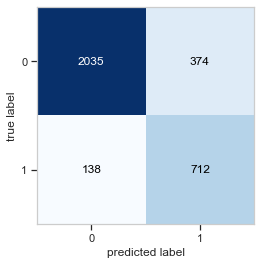

In [39]:
def classification_logistic(X_train,y_train,X_test,y_test,target,scoring_param='f1'):
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    from sklearn.model_selection import GridSearchCV
    import matplotlib.pyplot as plt
    
    lreg = LogisticRegression()

    reg_param = [0.3, 0.5, 1.0]

    param_grid = {'C': reg_param}

    gs = GridSearchCV(estimator=lreg, param_grid=param_grid, scoring=scoring_param, cv=5, n_jobs=-1)

    gs.fit(X_train, y_train)

    print ("\nBest Score = {}".format(gs.best_score_))
    print ("\nBest params: {}".format(gs.best_params_))
    print ("\nBest Estimator: {}".format(gs.best_estimator_))

    lreg = gs.best_estimator_

    # Coefficients of logistic Regression
    print ("\n Logistic Regression Model \n") 
    print (sorted(zip(df.columns[df.columns != target], np.ravel(lreg.coef_))))

    print("Training Error")
    print("Accuracy score = ", accuracy_score(y_train, lreg.predict(X_train)))
    print("Precision score = ", precision_score(y_train, lreg.predict(X_train)))
    print("Recall score = ", recall_score(y_train, lreg.predict(X_train)))
    print("F1 score = ", f1_score(y_train, lreg.predict(X_train)))


    print("Test Error")
    print("Accuracy score = ", accuracy_score(y_test, lreg.predict(X_test)))
    print("Precision score = ", precision_score(y_test, lreg.predict(X_test)))
    print("Recall score = ", recall_score(y_test, lreg.predict(X_test)))
    print("F1 score = ", f1_score(y_test, lreg.predict(X_test)))

    # Plot confusion matrix
    from mlxtend.evaluate import confusion_matrix
    from mlxtend.plotting import plot_confusion_matrix
    import matplotlib.pyplot as plt
    y_pred = lreg.predict(X_test)
    cm = confusion_matrix(y_target=y_test, 
                      y_predicted=y_pred, 
                      binary=True)
    fig, ax = plot_confusion_matrix(conf_mat=cm)
    plt.show()
    return lreg 

lreg = classification_logistic(X_train,y_train,X_test,y_test,'converted')

#### Random Forest Classification

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

Best Score = 0.8434653333192612

Best params: {'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 100}

Best Estimator: RandomForestClassifier(max_depth=4)


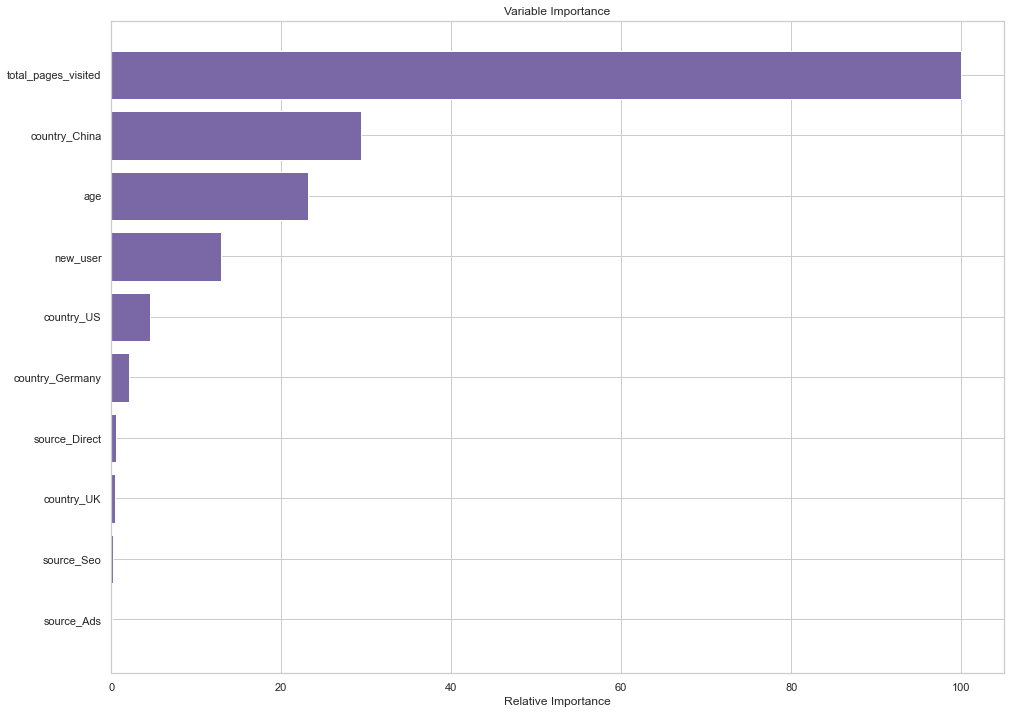

Training Error
Accuracy score =  0.8399581589958159
Precision score =  0.8357438016528925
Recall score =  0.8462343096234309
F1 score =  0.840956340956341
Test Error
Accuracy score =  0.8241791960724149
Precision score =  0.6207497820401047
Recall score =  0.8376470588235294
F1 score =  0.71306960440661


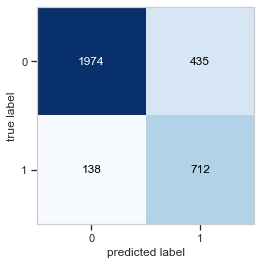

In [40]:
def classification_randomForest(X_train, y_train, X_test, y_test, target, scoring_param='f1'):
    from sklearn.model_selection import GridSearchCV
    from sklearn.ensemble import RandomForestClassifier
    import matplotlib.pyplot as plt
    import numpy as np
    
    rf = RandomForestClassifier()
    print(rf.get_params())
    
    estimator_range = [10, 100, 1000]
    feature_range = ['sqrt', 'log2']
    depth_range = [3, 4]
    #Overall 3*2*2 = 12 combinations with five times CV

    param_grid = {'n_estimators': estimator_range, 'max_features': feature_range, 'max_depth' : depth_range}

    gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring=scoring_param, cv=2, n_jobs=-1)

    gs.fit(X_train,y_train)

    print("\nBest Score = {}".format(gs.best_score_))
    print("\nBest params: {}".format(gs.best_params_))
    print("\nBest Estimator: {}".format(gs.best_estimator_))
    
    rf = gs.best_estimator_
    
    feature_importance = rf.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.figure(figsize=(16, 12))
    plt.barh(pos, feature_importance[sorted_idx], align='center', color='#7A68A6')
    plt.yticks(pos, np.asanyarray(df.columns[df.columns != target])[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()
    
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    print("Training Error")
    print("Accuracy score = ", accuracy_score(y_train, rf.predict(X_train)))
    print("Precision score = ", precision_score(y_train, rf.predict(X_train)))
    print("Recall score = ", recall_score(y_train, rf.predict(X_train)))
    print("F1 score = ", f1_score(y_train, rf.predict(X_train)))


    print("Test Error")
    print("Accuracy score = ", accuracy_score(y_test, rf.predict(X_test)))
    print("Precision score = ", precision_score(y_test, rf.predict(X_test)))
    print("Recall score = ", recall_score(y_test, rf.predict(X_test)))
    print("F1 score = ", f1_score(y_test, rf.predict(X_test)))

    # Plot confusion matrix
    from mlxtend.evaluate import confusion_matrix
    from mlxtend.plotting import plot_confusion_matrix
    import matplotlib.pyplot as plt
    y_pred = rf.predict(X_test)
    cm = confusion_matrix(y_target=y_test, 
                      y_predicted=y_pred, 
                      binary=True)
    fig, ax = plot_confusion_matrix(conf_mat=cm)
    plt.show()
    return rf
    
rf = classification_randomForest(X_train, y_train, X_test, y_test, 'converted')

#### Gradient Boosting Classification

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}

Best Score = 0.8690621046506954

Best params: {'learning_rate': 0.2, 'max_depth': 7, 'max_features': 'log2', 'n_estimators': 10}

Best Estimator: GradientBoostingClassifier(learning_rate=0.2, max_depth=7, max_features='log2',
                           n_estimators=10)


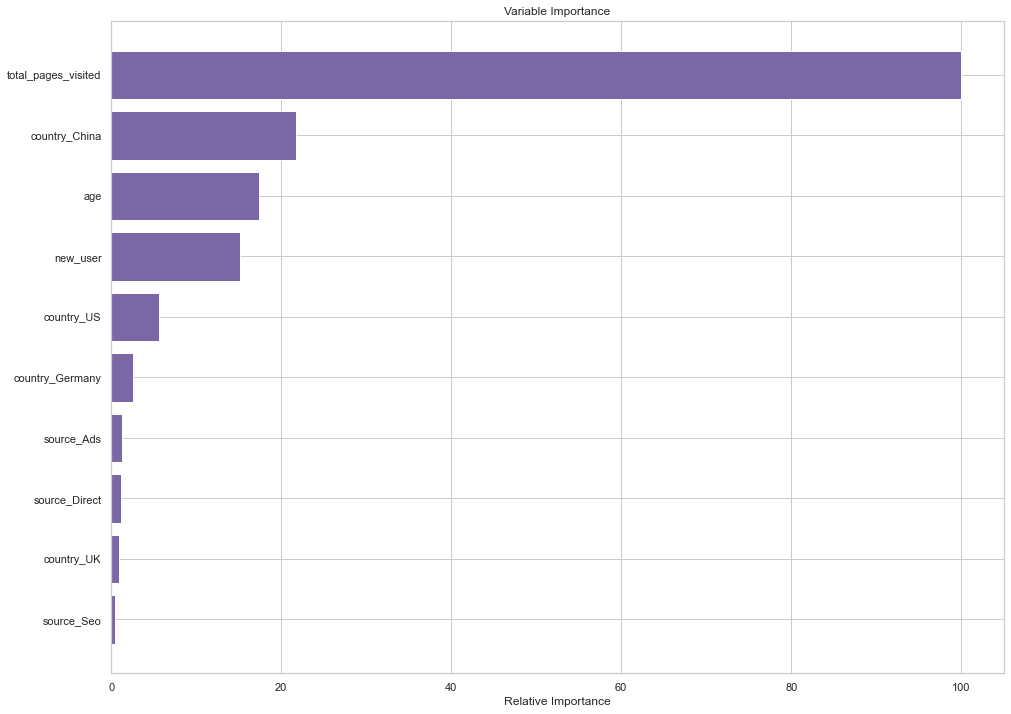

Training Error
Accuracy score =  0.8692991631799163
Precision score =  0.8389822371579453
Recall score =  0.9140167364016737
F1 score =  0.8748936170212767
Test Error
Accuracy score =  0.8260202516109236
Precision score =  0.620016963528414
Recall score =  0.86
F1 score =  0.7205519960571711


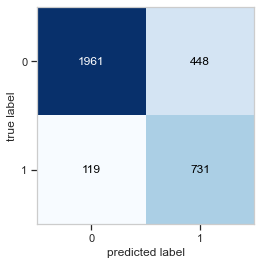

In [41]:
def classification_gradientBoosting(X_train, y_train, X_test, y_test, target, scoring_param='f1'):
    from sklearn.model_selection import GridSearchCV
    from sklearn.ensemble import GradientBoostingClassifier
    import matplotlib.pyplot as plt
    import numpy as np
    
    gb = GradientBoostingClassifier()
    print(gb.get_params())
    
    estimator_range = [10, 100, 1000]
    learning_rate_range = [0.1, 0.2]
    max_depth_range = [3, 5, 7]
    feature_range = ['sqrt', 'log2']

    param_grid = {'n_estimators': estimator_range, 'learning_rate': learning_rate_range, 'max_depth': max_depth_range, 'max_features': feature_range}

    gs = GridSearchCV(estimator=gb, param_grid=param_grid, scoring=scoring_param, cv=2, n_jobs=-1)
    gs.fit(X_train,y_train)
    
    print ("\nBest Score = {}".format(gs.best_score_))
    print ("\nBest params: {}".format(gs.best_params_))
    print ("\nBest Estimator: {}".format(gs.best_estimator_))
    
    gb = gs.best_estimator_
    
    feature_importance = gb.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.figure(figsize=(16, 12))
    plt.barh(pos, feature_importance[sorted_idx], align='center', color='#7A68A6')
    plt.yticks(pos, np.asanyarray(df.columns[df.columns != target])[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()
    
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    print("Training Error")
    print("Accuracy score = ", accuracy_score(y_train, gb.predict(X_train)))
    print("Precision score = ", precision_score(y_train, gb.predict(X_train)))
    print("Recall score = ", recall_score(y_train, gb.predict(X_train)))
    print("F1 score = ", f1_score(y_train, gb.predict(X_train)))

    print("Test Error")
    print("Accuracy score = ", accuracy_score(y_test, gb.predict(X_test)))
    print("Precision score = ", precision_score(y_test, gb.predict(X_test)))
    print("Recall score = ", recall_score(y_test, gb.predict(X_test)))
    print("F1 score = ", f1_score(y_test, gb.predict(X_test)))

    # Plot confusion matrix
    from mlxtend.evaluate import confusion_matrix
    from mlxtend.plotting import plot_confusion_matrix
    import matplotlib.pyplot as plt
    y_pred = gb.predict(X_test)
    cm = confusion_matrix(y_target=y_test, 
                      y_predicted=y_pred, 
                      binary=True)
    fig, ax = plot_confusion_matrix(conf_mat=cm)
    plt.show()
    
    return gb
    
gb = classification_gradientBoosting(X_train, y_train, X_test, y_test, 'converted')

In [42]:
X.columns

Index(['age', 'new_user', 'total_pages_visited', 'country_China',
       'country_Germany', 'country_UK', 'country_US', 'source_Ads',
       'source_Direct', 'source_Seo'],
      dtype='object')

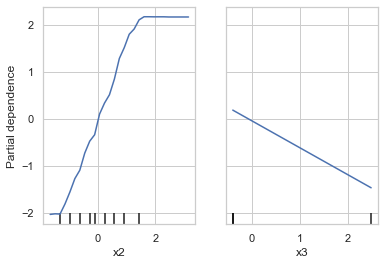

In [53]:
# Partial dependence plot for interpretation of the model (defined only on training data)

from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(gb, X_train, features =[2,3]) # The features are the column numbers from the X array 

# One-way PDPs tell us about the interaction between the target response and the target feature (e.g. linear, non-linear)
# Also it can tell direction ( +ve or -ve relationship)

### Threshold/Cut-off Analysis - ROC or PR curve

#### ROC 

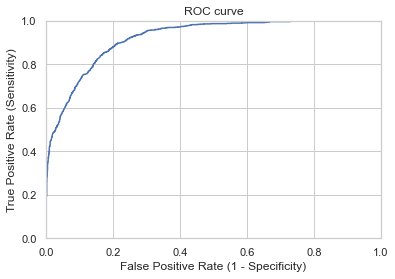

In [44]:
# Plot ROC Curve for the best performing classifier e.g. gradient boosting

from sklearn.metrics import roc_curve
y_pred_prob = gb.predict_proba(X_test) 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [45]:
# define a function that accepts a threshold and prints sensitivity and specificity
def evaluate_roc_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])
    
# Aim is to maximize both sensitivity and specificity
evaluate_roc_threshold(0.5224)

Sensitivity: 0.8541176470588235
Specificity: 0.8268991282689913


In [46]:
# Find optimal cut off point 
# The optimal cut off would be where tpr is high and fpr is low
# tpr - (1-fpr) is zero or near to zero is the optimal cut off point

i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc.loc[(roc.tf-0).abs().argsort()[:1]]

,fpr,tpr,1-fpr,tf,thresholds
470,0.162308,0.837647,0.837692,-0.000045,0.549223


Confusion Matrix


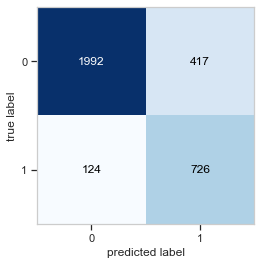

Accuracy score =  0.8339981589444615
Precision score =  0.6351706036745407
Recall score =  0.8541176470588235
F1 score =  0.7285499247365781


In [47]:
# Classifier performance on the new threshold

# store the predicted probabilities for class 1
y_pred_prob = [gb.predict_proba(X_test)[:,1]]
from sklearn.preprocessing import binarize
# it will return 1 for all values above optimum threshold and 0 otherwise
# results are 2D so we slice out the first column
y_pred_class = binarize(y_pred_prob, threshold = 0.5222)[0]

# Print confusion matrix
print("Confusion Matrix")
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(y_target=y_test, 
                      y_predicted=y_pred_class, 
                      binary=True)

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

# Print Classification metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy score = ", accuracy_score(y_test, y_pred_class))
print("Precision score = ", precision_score(y_test, y_pred_class))
print("Recall score = ", recall_score(y_test, y_pred_class))
print("F1 score = ", f1_score(y_test, y_pred_class))

#### PR

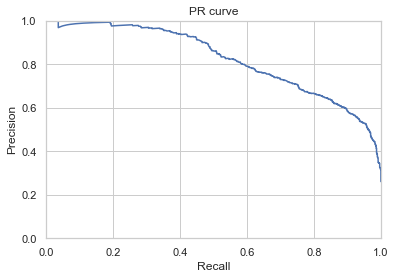

In [48]:
# Plot PR Curve for the best performing classifier e.g. gradient boosting
from sklearn.metrics import precision_recall_curve
y_pred_prob = gb.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob[:,1])


plt.plot(recall, precision)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)

In [49]:
# define a function that accepts a threshold and prints precision and recall
def evaluate_pr_threshold(threshold):
    pt = zip(thresholds,precision)
    rt = zip(thresholds,recall)
    print('Precision:', [p for p in pt if p[0] > threshold][0][1])
    print('Recall:', [r for r in rt if r[0] > threshold][0][1])
    
# Aim is to maximize both precision and recall
evaluate_pr_threshold(0.7)

Precision: 0.7680115273775217
Recall: 0.6270588235294118


In [50]:
# Find optimal cut off point 
# The optimal cut off would be where precision and recall are both high 
# precision - recall is zero or near to zero is the optimal cut off point

i = np.arange(len(thresholds)) # index for df
recall = recall[:-1] # recall : array, shape = [n_thresholds + 1]
precision = precision[:-1] # precision : array, shape = [n_thresholds + 1]
roc = pd.DataFrame({'recall' : pd.Series(recall, index=i),'precision' : pd.Series(precision, index = i), 'tf' : pd.Series(precision - recall, index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc.loc[(roc.tf-0).abs().argsort()[:1]]

,recall,precision,tf,thresholds
1592,0.721176,0.721176,0.0,0.648092


Confusion Matrix


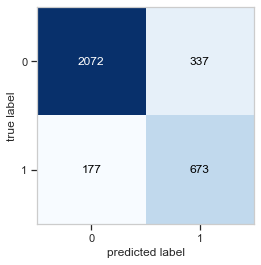

Accuracy score =  0.8422829088677508
Precision score =  0.6663366336633664
Recall score =  0.7917647058823529
F1 score =  0.7236559139784946


In [51]:
# Classifier performance on the new threshold

# store the predicted probabilities for class 1
y_pred_prob = [gb.predict_proba(X_test)[:,1]]
from sklearn.preprocessing import binarize
# it will return 1 for all values above optimum threshold and 0 otherwise
# results are 2D so we slice out the first column
y_pred_class = binarize(y_pred_prob, threshold=0.5971)[0]

# Print confusion matrix
print("Confusion Matrix")
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(y_target=y_test, 
                      y_predicted=y_pred_class, 
                      binary=True)

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

# Print Classification metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy score = ", accuracy_score(y_test, y_pred_class))
print("Precision score = ", precision_score(y_test, y_pred_class))
print("Recall score = ", recall_score(y_test, y_pred_class))
print("F1 score = ", f1_score(y_test, y_pred_class))

##### Analyzing Error & Re-iterating - Some tips

* Feature Engineering
* Cluster and then apply different classification model for each cluster
* Ensemble Technique
* If missing values were large initially, analyze the effect of imputing or apply other imputation techniques